In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mibitrans.analysis.mass_balance import mass_balance
from mibitrans.data.read import AdsorptionParameters
from mibitrans.data.read import DegradationParameters
from mibitrans.data.read import HydrologicalParameters
from mibitrans.data.read import ModelParameters
from mibitrans.data.read import SourceParameters
from mibitrans.transport.domenico import InstantReaction
from mibitrans.transport.domenico import LinearDecay
from mibitrans.transport.domenico import NoDecay
from mibitrans.visualize.plot_line import breakthrough
from mibitrans.visualize.plot_line import centerline
from mibitrans.visualize.plot_line import transverse
from mibitrans.visualize.plot_surface import plume_2d
from mibitrans.visualize.plot_surface import plume_3d
from mibitrans.visualize.show_mass_balance import generate_mass_balance_tables
from mibitrans.visualize.show_mass_balance import visualize_mass_balance

The examples below uses example data originating from BIOSCREEN, the Excel based modeling software this package took inspiration from. As it was developed in the USA, length units are in ft. We'll use a conversion factor to express length in m instead.

In [2]:
ft = 3.281 # factor to convert ft to m

### Input by dataclasses

mibitrans use dataclasses located in mibitrans.data.read to handle data input. This can be There are five input dataclasses, each for a different category of parameters. To avoid any mistakes, units of input parameters should be the ones specified. When using different units, make sure that they are consistent throughout the entire modelling process.

##### Hydrological parameters

Contains parameters that are inherent to the aquifer properties; flow velocity, porosity and dispersivity. Flow velocity can alternatively be calculated from the hydraulic conductivity and hydraulic gradient. 

In [3]:

hydro = HydrologicalParameters(
    velocity=113.8/ft/365,   # Groundwater flow velocity, in [m/day]
    porosity=0.25,           # Effective soil porosity [-]
    alpha_x=13.3/ft,         # Longitudinal dispersivity, in [m]
    alpha_y=1.3/ft,          # Transverse horizontal dispersivity, in [m]
    alpha_z=0                # Transverse vertical dispersivity, in [m]
)

# Alternative by specifying hydraulic gradient and hydraulic conductivity
hydro = HydrologicalParameters(
    h_gradient=0.048,        # Hydraulic gradient [-]
    h_conductivity=0.495,    # Hydraulic conductivity [m/day]
    porosity=0.25,           # Effective soil porosity [-]
    alpha_x=13.3/ft,         # Longitudinal dispersivity, in [m]
    alpha_y=1.3/ft,          # Transverse horizontal dispersivity, in [m]
    alpha_z=0                # Transverse vertical dispersivity, in [m]
)

# And then check the value:
print("The calculated groundwater flow velocity is: ", hydro.velocity, r"m/d")

# Any other input parameters can be requested by specifying the argument;
print(f"The dispersivity values are: {hydro.alpha_x}m, {hydro.alpha_y}m and {hydro.alpha_z}m, for the x, y and z directions respectively.")

# When in doubt what input and attributes a dataclass has, use ClassName? to see the documentation:
HydrologicalParameters?

The calculated groundwater flow velocity is:  0.09504 m/d
The dispersivity values are: 4.053642182261505m, 0.3962206644315757m and 0m, for the x, y and z directions respectively.


##### Adsorption parameters
Handles the retardation factor. Which can be given simply as a value >= 1. Alternatively, the adsorption is calculated from the soil bulk density, paratition coefficient and the fraction of organic carbon in the soil. Note that calculation of retardation factor requires porosity as well, which is already provided in HydrologicalParameters. The calculation of retardation will therefore be automatically performed in the analytical equation. It can be manually calculated using the calculate_retardation method as well.

In [4]:
ads = AdsorptionParameters(
    # Retardation factor for transported contaminants
    retardation=1
)

# Alternatively, calculate the retardation factor by supplying soil and contaminant properties
ads = AdsorptionParameters(
    # Soil bulk density in [g/m^3]
    bulk_density=1.7,
    # Partition coefficient of the transported contaminant to soil organic matter, in [m^3/g]
    partition_coefficient=38,
    # Fraction of organic material in the soil [-]
    fraction_organic_carbon=5.7e-5
)

# Calculate the retardation factor beforehand to see its value by specifying the porosity
ads.calculate_retardation(porosity=hydro.porosity)

# And then check the value:
print("The calculated retardation value is: ", ads.retardation)

The calculated retardation value is:  1.0147288


##### Degradation parameters

Handles the degradation parameter input. Linear decay models only need either the contaminant decay rate or half life. Input for the instant reaction model is somewhat more involved, needing electron donor and acceptor concentrations. For utilization factors (amount of electron donor/acceptor used/generated by biodegradation), the values for BTEX degradation are used by default. They can be manually changed using the utilization_factor method of DegradationParameters.

In [5]:
deg = DegradationParameters(
    decay_rate=0.0127           # Contaminant first order decay rate in [1/days]
)

# Alternatively, specify the contaminant half life, or electron acceptor/donor concentrations
deg = DegradationParameters(
    # Contaminant half life, in [days]
    half_life=54.75,
    # Difference between background oxygen and current oxygen concentration in groundwater, in [g/m^3]
    delta_oxygen=1.65,
    # Difference between background nitrate and current nitrate concentration in groundwater, in [g/m^3]
    delta_nitrate=0.7,
    # Current ferrous iron concentration in groundwater, in [g/m^3]
    ferrous_iron=16.6,
    # Difference between background sulfate and current sulfate concentration in groundwater, in [g/m^3]
    delta_sulfate=22.4,
    # Current methane concentration in groundwater, in [g/m^3]
    methane=6.6
)

# For the domenico instant reaction model, electron acceptor utilization factors can be manually changed
# from their default values;
deg.set_utilization_factor(
    # utilization factor of oxygen, as mass of oxygen consumed per mass of biodegradated contaminant [g/g].
    util_oxygen=2,
    # utilization factor of nitrate, as mass of nitrate consumed per mass of biodegrated contaminant [g/g].
    util_nitrate=1,
    # utilization factor of ferrous iron, as mass of ferrous iron generated per mass of biodegradated contaminant [g/g].
    util_ferrous_iron=4,
    # utilization factor of sulfate, as mass of sulfate consumed per mass of biodegradated contaminant [g/g].
    util_sulfate=3,
    # utilization factor of methane, as mass of methane generated per mass of biodegrated contaminant [g/g].
    util_methane=5,
)

print("The altered utilization factor object is:", deg.utilization_factor)

# For the rest of the example, we will go back to the default values
deg.set_utilization_factor()
print("The default utilization factor object is:", deg.utilization_factor)

# Utilization factor data can also be extracted as dictionary if needed
util_dictionary = deg.utilization_factor.dictionary
print("The utilization factors as dictionary: ", util_dictionary)


The altered utilization factor object is: UtilizationFactor(util_oxygen=2, util_nitrate=1, util_ferrous_iron=4, util_sulfate=3, util_methane=5)
The default utilization factor object is: UtilizationFactor(util_oxygen=3.14, util_nitrate=4.9, util_ferrous_iron=21.8, util_sulfate=4.7, util_methane=0.78)
The utilization factors as dictionary:  {'util_oxygen': 3.14, 'util_nitrate': 4.9, 'util_ferrous_iron': 21.8, 'util_sulfate': 4.7, 'util_methane': 0.78}


##### Source parameters

Takes input of the dimensions of and concentrations at the contaminant source. The source is treated as a seperate phase, which dissolves into the groundwater over time. The source is assumed to be in symmetrical in its center, and concentrations decrease from the center to the fringes. Furthermore, the source is assumed to be constant over its depth. The transverse horizontal dimension (or width) of the source is divided into zones, which span a certain distance measured from the center of the source, each with an associated concentration. For example, a source can have a concentration of $10g/m^3$ $7m$ left and right from the source center, and a concentration of $5g/m^3$ up to $20m$ from the source center. This would then be entered as source_zone_boundary = $[7,20]$ and source_zone_concentration = $[10,5]$. The source can be a single zone with a single concentration as well.

By giving a total mass of the contaminant source, the amount of solid-phase contaminant, and with that, the source zone concentrations, diminish over time. The rate at which this occurs depends on the flow velocity in the aquifer and the size of the source zone. The source zone can be set to be considered infinite as well, meaning that the concentrations will not diminish over time.

0 19.811033221578786
1 11.277049679975617
2 2.133495885400792


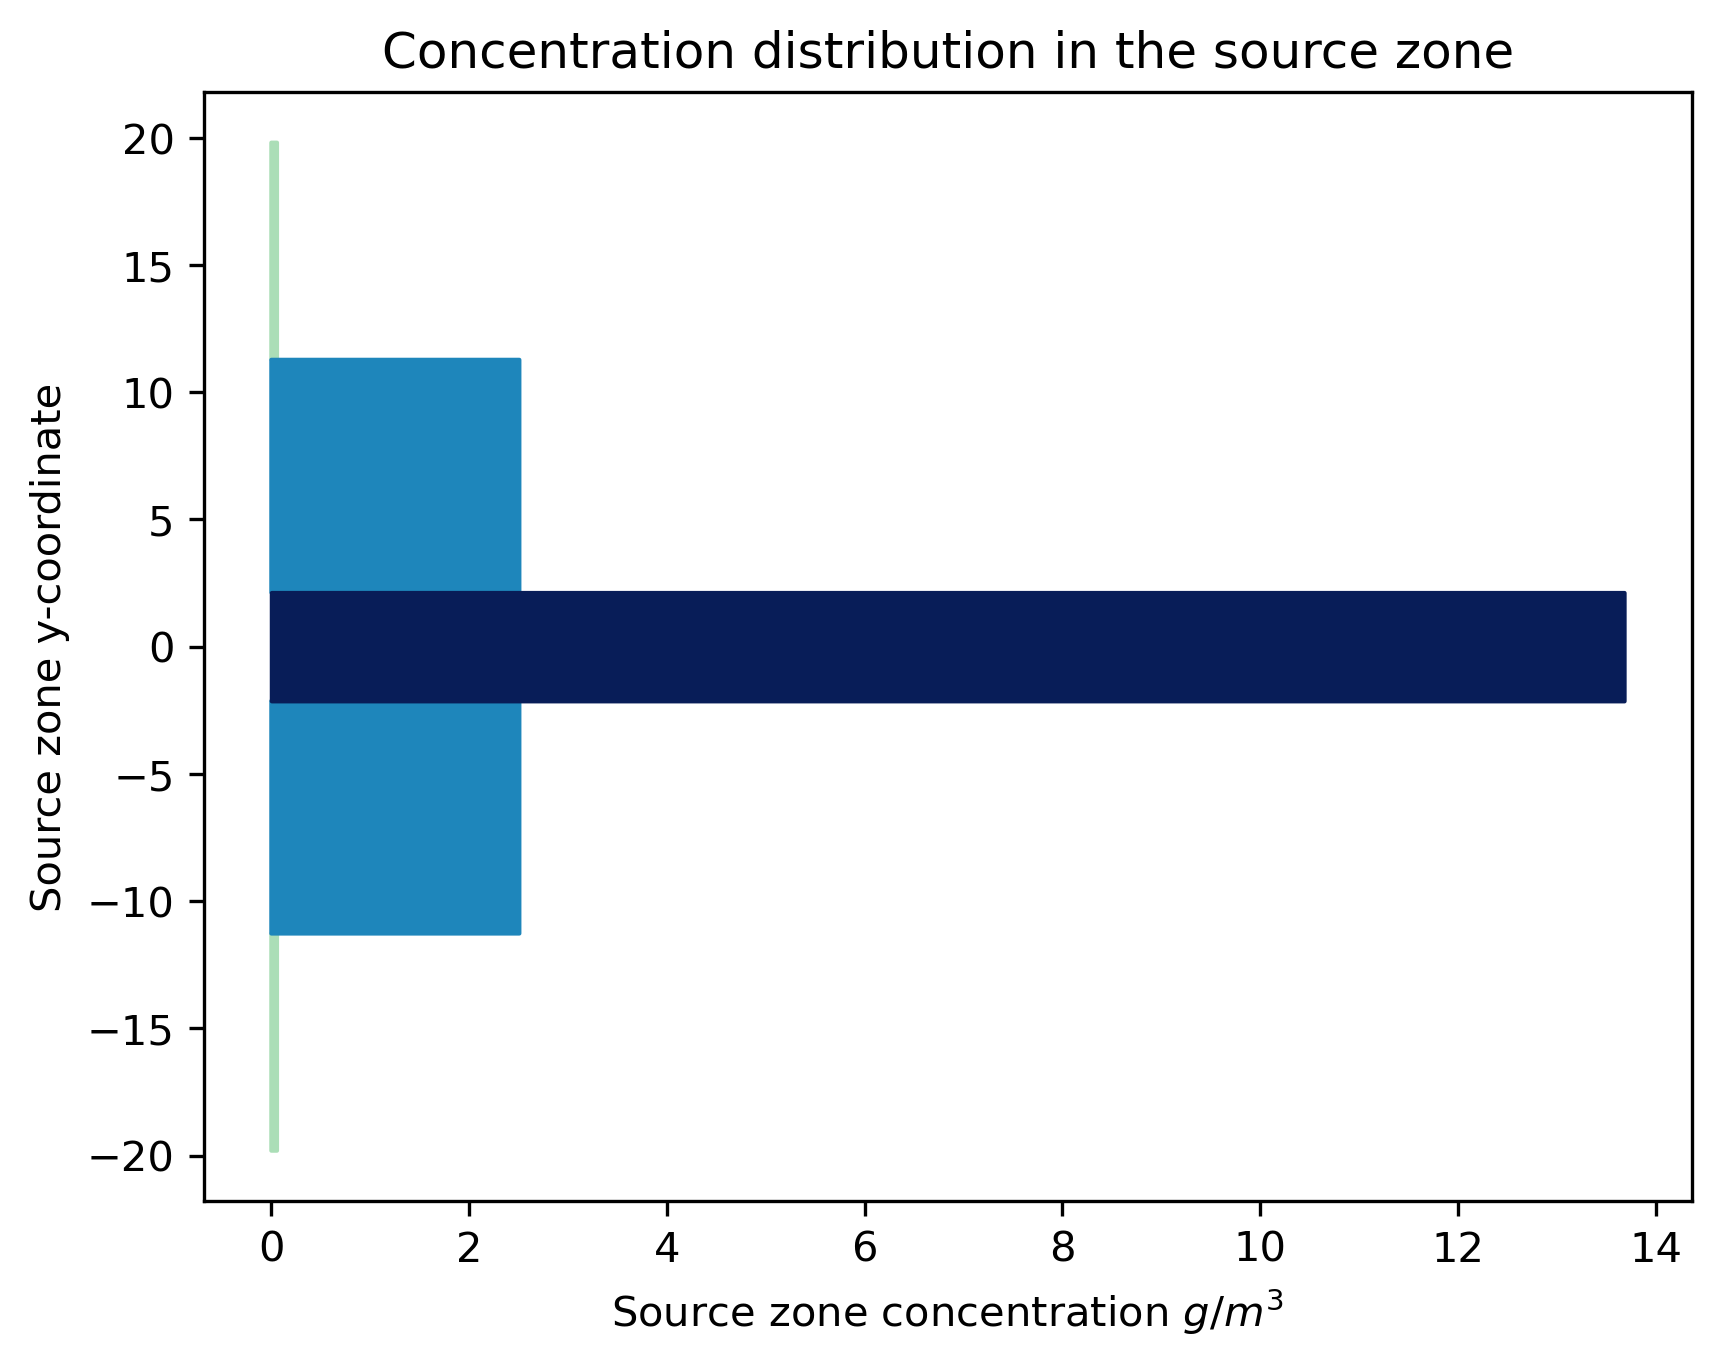

In [6]:
# Input for a simple source zone with a width of 19.8m (65ft) and a continuous input (infinite source mass)
source = SourceParameters(
    # Source zone boundaries, in [m] (simply using a float instead of a numpy array for
    # single source zone input will work as well)
    source_zone_boundary=np.array([65/ft]),
    # Source zone concentrations, in [g/m^3]
    source_zone_concentration=np.array([5]),
    # Source depth extent, in [m]
    depth=10/ft,
    # Source mass, considered infinite
    total_mass="inf"
)

# Alternatively, specify a source mass to allow for source decay
source = SourceParameters(
    source_zone_boundary=np.array([7/ft, 37/ft, 65/ft]),
    source_zone_concentration=np.array([13.68, 2.508, 0.057]),
    depth=10/ft,
    total_mass=2000000
)

# Visualize what the source zone looks like to check your input:
source.visualize()
plt.show()

##### Model parameters

Accepts input for the model dimensions and discretization. Model length is the extent in the (x) direction parallel to the groundwater flow direction. The model width is the extent of the model perpendicular (y) to the groundwater flow direction. Step size of the spatial dimensions is handled with dx and dy. Ensure that the source zone fits inside of the given model width. 

In [7]:

model = ModelParameters(
    # Model extent in the longitudinal (x) direction in [m].
    model_length = 320/ft,
    # Model extent in the transverse horizontal (y) direction in [m].
    model_width = 100/ft,
    # Model duration in [days].
    model_time = 6 * 365,
    # Model grid discretization step size in the longitudinal (x) direction, in [m].
    dx = 1/ft,
    # Model grid discretization step size in the transverse horizontal (y) direction, in [m].
    dy = 1/ft,
    # Model time discretization step size, in [days]
    dt = 365
)

##### Input checking

The dataclass inputs evaluates if the required input parameters are present, if they are of the correct data type and if they are in the expected domain.

In [8]:
# If not all required parameters are specified, an error will be shown;
# HydrologicalParameters needs the porosity, longitudinal dispersivity and transverse horizontal dispersivity as well.
fake_hydro = HydrologicalParameters(velocity = 1)

ValueError: HydrologicalParameters missing 3 arguments: ['porosity', 'alpha_x', 'alpha_y'].

In [25]:
# If the input datatype is not what is expected; source_zone_concentration expects a numpy array
# of the same length as the array given in source_zone_boundary.
fake_source = SourceParameters(
    source_zone_boundary = np.array([1,2,3]),
    source_zone_concentration = "this is a string, not an array",
    depth = 10,
    total_mass = "inf",
)

TypeError: source_zone_concentration must be a float, list or numpy array, but is <class 'str'> instead.

In [26]:
# Same goes for if the input parameter has a value outside of its valid domain; adsorption should have a value >= 1
fake_ads = AdsorptionParameters(
    retardation = 0.1
)

ValueError: retardation must be 1 or larger.

### Analytical models

Having entered the parameters, their objects can be passed to the transport equations. This is handled by the classes in mibitrans.transport.domenico. These classes generate the model grid and do some prior parameter calculations, before running the analytical equations. The model object can then be used to call attributes of the model or as input for other functions of mibitrans.

In [27]:
# No degradation transport model
ndeg = NoDecay(
    hydrological_parameters=hydro,
    adsorption_parameters=ads,
    source_parameters=source,
    model_parameters=model
)
# Linear degradation transport model
lindeg = LinearDecay(
    hydrological_parameters=hydro,
    adsorption_parameters=ads,
    degradation_parameters=deg,
    source_parameters=source,
    model_parameters=model
)
# Instant reaction degradation transport model
instdeg = InstantReaction(
    hydrological_parameters=hydro,
    adsorption_parameters=ads,
    degradation_parameters=deg,
    source_parameters=source,
    model_parameters=model
)

# Get resulting array with concentrations, and model x, y and t discretization from model object
cxyt, x, y, t = ndeg.cxyt, ndeg.x, ndeg.y, ndeg.t

The model classes check if they receive all required and the correct input dataclasses, ensuring model calculations will be performed without error.

In [12]:
# Will not work; hydrological_parameters should be a HydrologicalParameters class object.
fake_ndeg = NoDecay(
    hydrological_parameters=model,
    adsorption_parameters=ads,
    source_parameters=source,
    model_parameters=model
)

TypeError: Input argument hydrological_parameters should be <class 'mibitrans.data.read.HydrologicalParameters'>, but is <class 'mibitrans.data.read.ModelParameters'> instead.

In [13]:
# Will not work; instant reaction model requires the electron acceptor/donor concentrations to function.
fake_deg = DegradationParameters(half_life=1)
fake_inst = InstantReaction(
    hydrological_parameters=hydro,
    adsorption_parameters=ads,
    degradation_parameters=fake_deg,
    source_parameters=source,
    model_parameters=model
)

ValueError: Instant reaction model requires concentrations of ['delta_oxygen', 'delta_nitrate', 'ferrous_iron', 'delta_sulfate', 'methane'].

## Visualization

Now that the concentration distribution has been calculated, the contaminant plume can be visualized. This can be done as a 1D line plot over the plume center (found in mibitrans.visualize.plot_line), a 2D plot visualized as a flat surface (found in mibitrans.visualize.plot_surface) or a 2D plot visualized as a 3D surface (also found in mibitrans.visualize.plot_surface). This can be done simply by passing the model object to the plot functions.

#### Plotting centerline

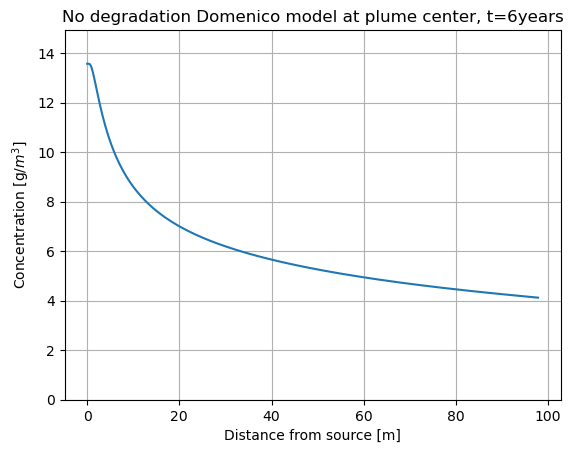

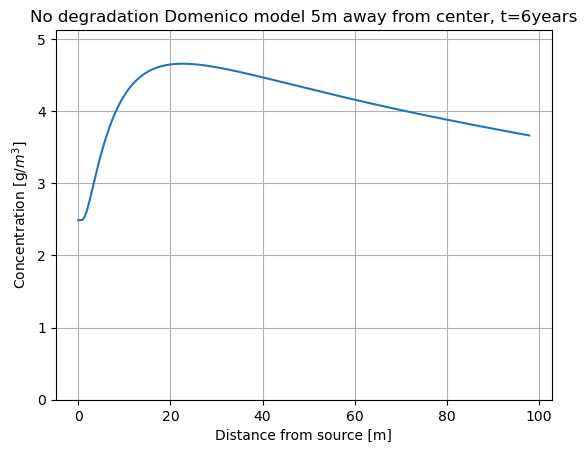

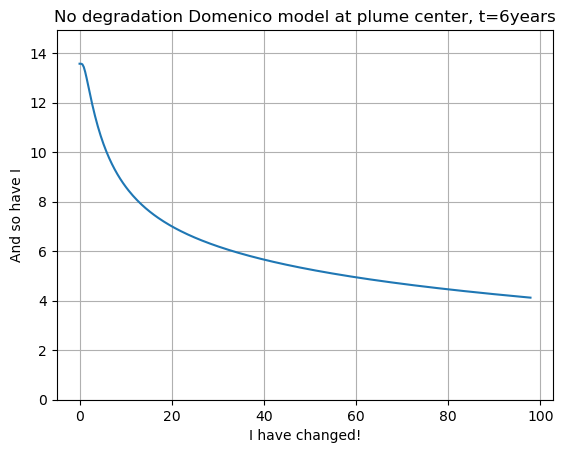

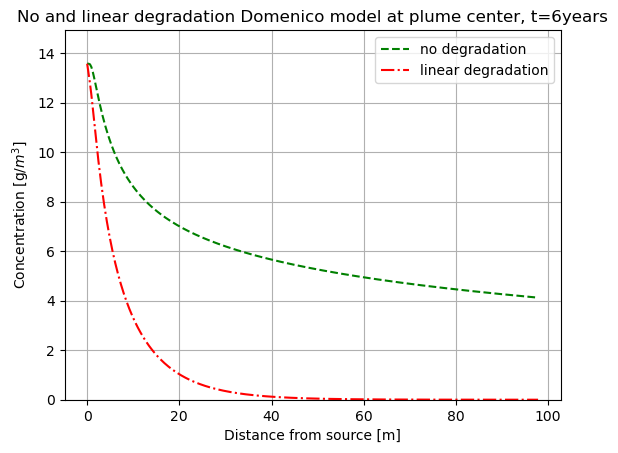

In [28]:
# Pass model object to plotting function
centerline(ndeg, time=6*365)
plt.title("No degradation Domenico model at plume center, t=6years")
plt.show()

# If you want to plot somewhere else on the plume, you can use the optional y_pos argument. It will show the
# concentration profile across the plume at the y location closest to given y_pos.
centerline(ndeg, time=6*365, y_position=5)
plt.title("No degradation Domenico model 5m away from center, t=6years")
plt.show()

# If you want you can change the plot settings to the ones you prefer
centerline(ndeg, time=6*365)
plt.title("No degradation Domenico model at plume center, t=6years")
plt.xlabel("I have changed!")
plt.ylabel("And so have I")
plt.show()

# Lastly, keyword arguments for plt.plot can be passed on through the function, and you can combine multiple plots.
centerline(ndeg, time=6*365, linestyle="--", color="green", label="no degradation")
centerline(lindeg, time=6*365, linestyle="-.", color="red", label="linear degradation")
plt.title("No and linear degradation Domenico model at plume center, t=6years")
plt.legend()
plt.show()


#### Plotting transverse distribution

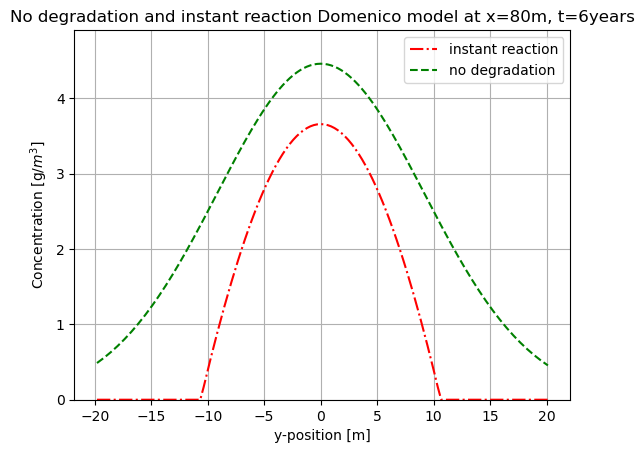

In [29]:
# Concentration distribution can also be plotted in the transverse direction
transverse(instdeg, time=6*365, x_position=80, linestyle="-.", color="red", label="instant reaction")
transverse(ndeg, time=6*365, x_position=80, linestyle="--", color="green", label="no degradation")

plt.title("No degradation and instant reaction Domenico model at x=80m, t=6years")
plt.legend()
plt.show()

#### Plotting breakthrough curve

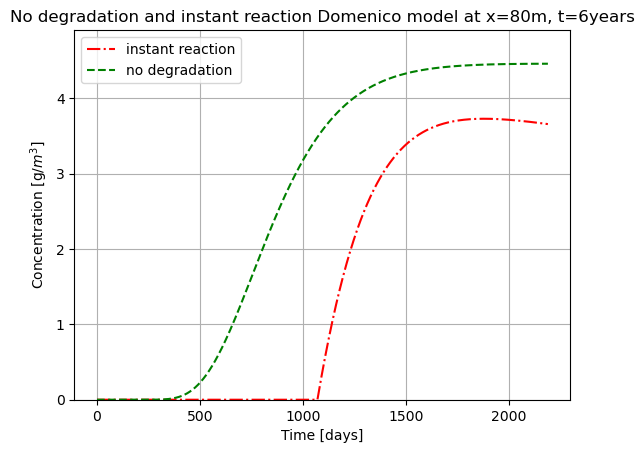

In [30]:
# Concentration distribution can also be plotted in the transverse direction
breakthrough(instdeg, x_position=80, linestyle="-.", color="red", label="instant reaction")
breakthrough(ndeg, x_position=80, linestyle="--", color="green", label="no degradation")

plt.title("No degradation and instant reaction Domenico model at x=80m, t=6years")
plt.legend()
plt.show()

#### Plotting in 2D

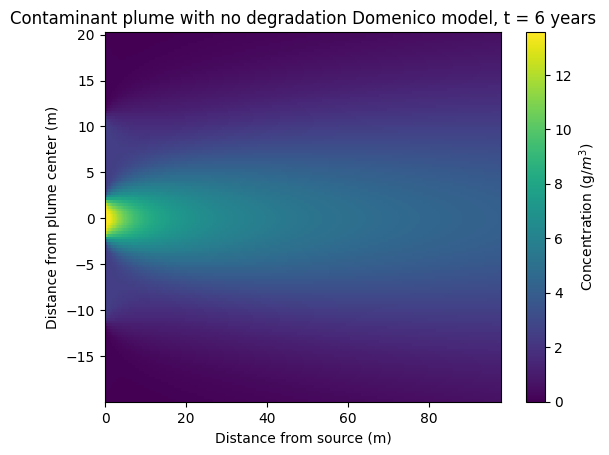

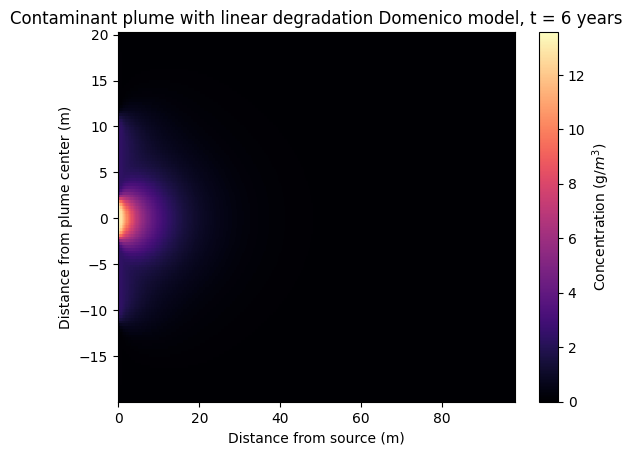

In [13]:
# Plot the x and y concentration distribution for linear decay model, uses plt.pcolormesh
plume_2d(ndeg, time=6*365)
plt.title("Contaminant plume with no degradation Domenico model, t = 6 years")
plt.show()

# Function passes plt.colormesh keyword arguments
plume_2d(lindeg, time=6*365, cmap="magma")
plt.title("Contaminant plume with linear degradation Domenico model, t = 6 years")
plt.show()

#### Plotting 2D in 3D

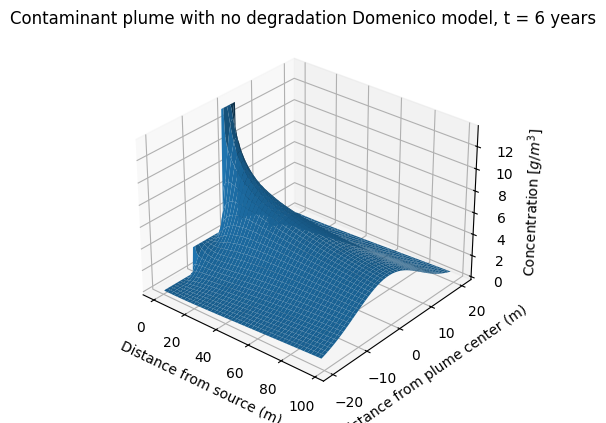

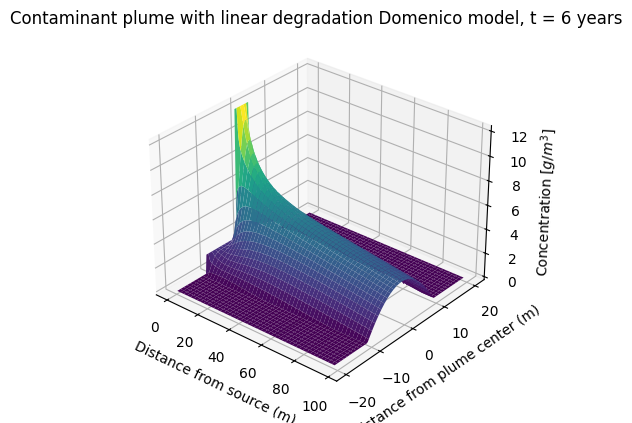

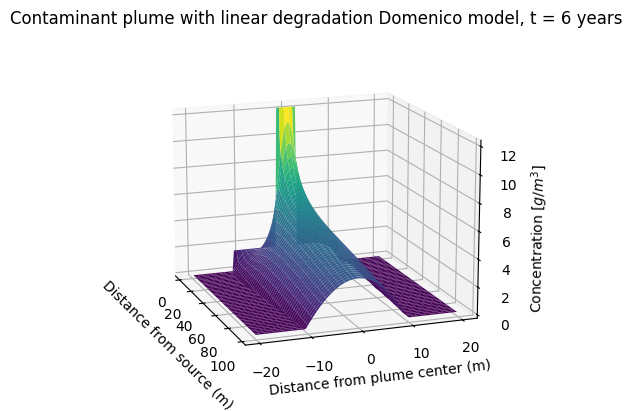

In [14]:
# Plot the x and y concentration distribution for no degradation decay model, uses plot_surface
plume_3d(ndeg, time=6*365)
plt.title("Contaminant plume with no degradation Domenico model, t = 6 years")
plt.show()

# Function passes plot_surface keyword arguments
plume_3d(instdeg, time=6*365, cmap="viridis")
plt.title("Contaminant plume with linear degradation Domenico model, t = 6 years")
plt.show()

# Function returns 'ax' object, use this to change view point of plot
ax = plume_3d(instdeg, time=6*365, cmap="viridis")
plt.title("Contaminant plume with linear degradation Domenico model, t = 6 years")
ax.view_init(elev=15, azim=340)
plt.show()

## Mass balance

To gain numerical information about mass transport in the model area, use the mass balance module in mibitrans.analysis.mass_balance. This returns a dictionary with mass values of each relevant model component (which varies depending on the model), in grams. Use the module mibitrans.visualization.show_mass_balance to show the mass balance in the form of a table.

In [15]:
# Set up mass balance object with given transport parameters
mb = mass_balance(ndeg, time=6*365)
# The dictionary can be printed as is, but it is not convenient for visualization
print("Mass balance as dictionary:", mb)
# Alternatively, it can visualized by the mass balance visualization module
visualize_mass_balance(mb)
# Furthermore, the dictionary can be accessed to do your own analysis or visualization.
print("The source mass after 6 years is:", mb["source_mass_t"])

{'time': np.int64(2190), 'source_mass_0': 2000000, 'source_mass_t': np.float64(1983383.9240515507), 'source_mass_change': np.float64(16616.075948449317), 'plume_mass_no_decay': np.float64(7655.381113175776), 'transport_outside_extent_nodecay': np.float64(8960.694835273542)}
MASS BALANCE FOR t = 2190
+---------------+-----------+
|  Source decay |  Mass (g) |
+---------------+-----------+
|   mass t = 0  |  2000000  |
| mass t = 2190 | 1983383.9 |
|   delta mass  |  16616.1  |
+---------------+-----------+
+---------------------------------------+----------+
|                No decay               | Mass (g) |
+---------------------------------------+----------+
|               plume mass              |  7655.4  |
| mass transported outside model extent |  8960.7  |
+---------------------------------------+----------+
The source mass after 6 years is: 1983383.9240515507


In [16]:
# The function generate_mass_balance_tables generates the tables printed by visualize_mass_balance.
# You can access and change the tables themselves as a prettytable object by calling this function instead.
table_source, table_nodecay, table_lindecay, table_instant, table_electron = generate_mass_balance_tables(mb)

table_source.add_row(["additional parameter", 1000])
print(table_source)

+----------------------+-----------+
|     Source decay     |  Mass (g) |
+----------------------+-----------+
|      mass t = 0      |  2000000  |
|    mass t = 2190     | 1983383.9 |
|      delta mass      |  16616.1  |
| additional parameter |    1000   |
+----------------------+-----------+
